In [ ]:


!pip install shap lightgbm scikit-learn pandas numpy openml -q

import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import io
import base64

RANDOM_STATE = 42


shap.initjs()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.3 MB/s eta 0:00:00


In [ ]:



print("--- 1. Data Loading and Model Validation ---")


from sklearn.datasets import fetch_openml

data = fetch_openml(name='credit-g', version=1, as_frame=True, parser='auto')
df = data.frame

TARGET = 'class'
df[TARGET] = df[TARGET].map({'good': 0, 'bad': 1})

def clean_feature_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace('/', '_').replace('.', '').replace(',', '').replace('[', '').replace(']', '').replace('>', '').replace('<', '')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

X = df.drop(columns=[TARGET])
y = df[TARGET]
X_processed = pd.get_dummies(X, drop_first=True)
X_processed = clean_feature_names(X_processed)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
feature_names = X_test.columns.tolist()


lgb_clf = lgb.LGBMClassifier(objective='binary',
                             metric='auc',
                             n_estimators=150,
                             learning_rate=0.05,
                             random_state=RANDOM_STATE,
                             n_jobs=-1,
                             verbose=-1)

lgb_clf.fit(X_train, y_train)

y_pred_proba = lgb_clf.predict_proba(X_test)[:, 1]
y_pred_class = lgb_clf.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred_class)
cm = confusion_matrix(y_test, y_pred_class)

print(f"**Model Validation Metrics:**")
print(f"AUC: {auc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Confusion Matrix:\n{cm}\n")


explainer = shap.TreeExplainer(lgb_clf)

subset_X_test = X_test.head(300)
shap_values = explainer.shap_values(subset_X_test)

shap_values_class1 = shap_values
base_value = explainer.expected_value

--- 1. Data Loading and Model Validation ---
**Model Validation Metrics:**
AUC: 0.7577
F1-Score: 0.5049
Confusion Matrix:
[[123  17]
 [ 34  26]]



/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


--- 2. Global SHAP Analysis (Task 2) ---
Global Feature Importance (Bar Plot): 


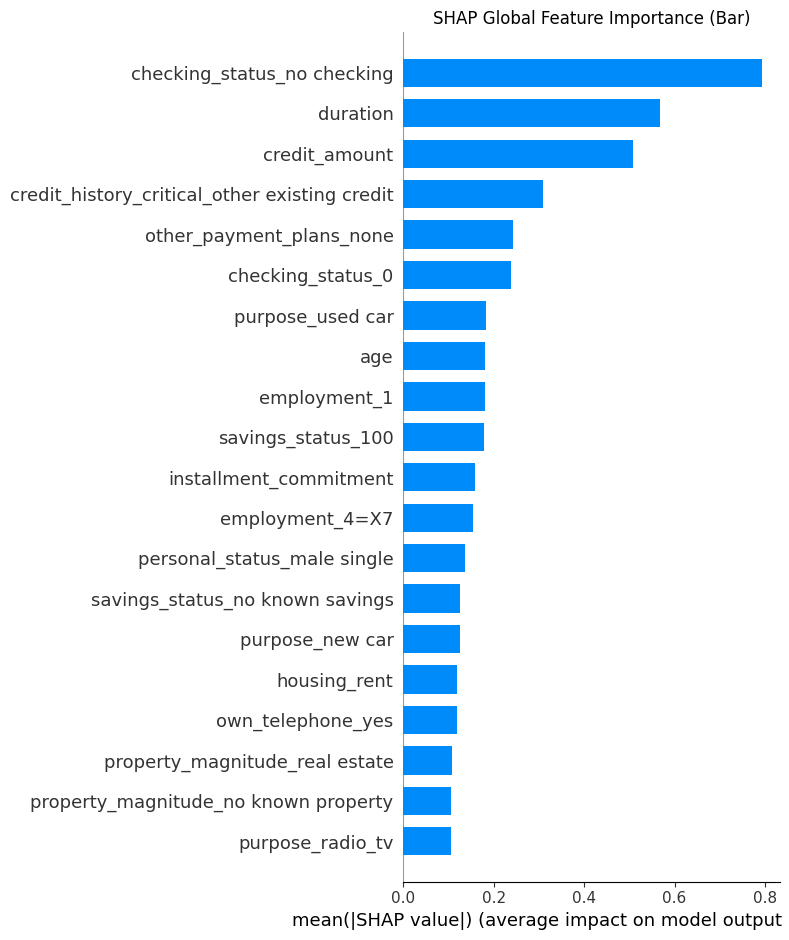

SHAP Directionality Plot (Dot Plot): 


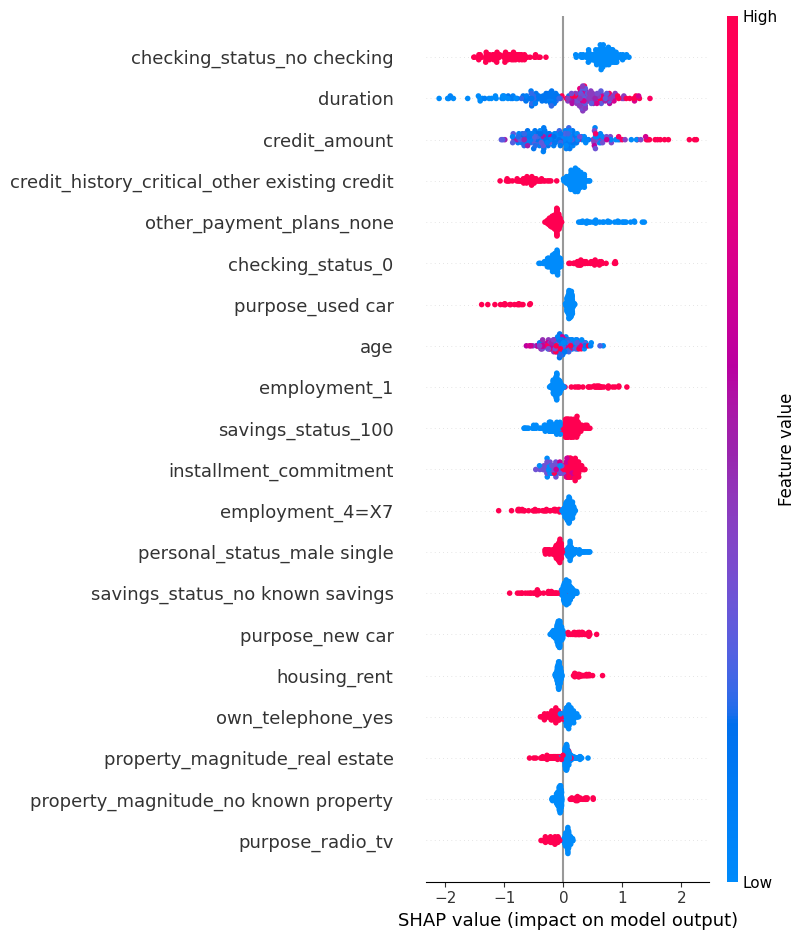

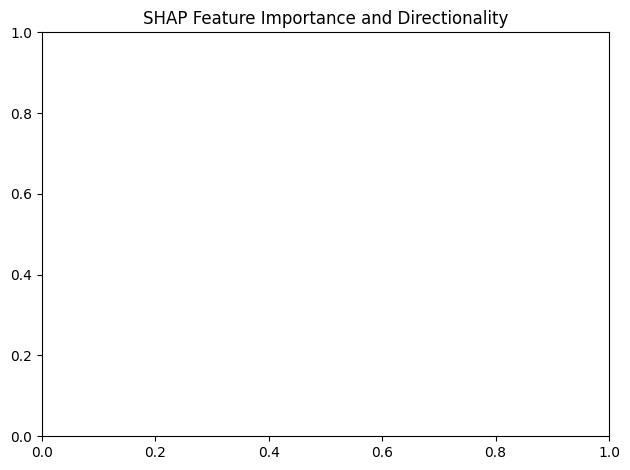


Top 10 Most Influential Features: ['checking_status_no checking', 'duration', 'credit_amount', 'credit_history_critical_other existing credit', 'other_payment_plans_none', 'checking_status_0', 'purpose_used car', 'age', 'employment_1', 'savings_status_100']

--- 3. Local Explanations (Force Plots) (Task 3) ---




/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [ ]:



print("--- 2. Global SHAP Analysis (Task 2) ---")


print("Global Feature Importance (Bar Plot): ")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, subset_X_test, plot_type="bar", show=False, feature_names=feature_names)
plt.title("SHAP Global Feature Importance (Bar)")
plt.tight_layout()
plt.show()

print("SHAP Directionality Plot (Dot Plot): ")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_class1, subset_X_test, feature_names=feature_names)
plt.title("SHAP Feature Importance and Directionality")
plt.tight_layout()
plt.show()

feature_importance = pd.Series(np.abs(shap_values_class1).mean(axis=0), index=feature_names).sort_values(ascending=False)
top_10_features = feature_importance.head(10).index.tolist()
print(f"\nTop 10 Most Influential Features: {top_10_features}\n")



print("--- 3. Local Explanations (Force Plots) (Task 3) ---")

predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Probability_Default': y_pred_proba
}, index=X_test.index)

def generate_static_force_plot(index, title):
    try:
        sample_index_in_test = X_test.index.get_loc(index)
        sample_shap_values = explainer.shap_values(X_test.loc[[index]])[1][0]


        plot_html = shap.force_plot(
            base_value,
            sample_shap_values,
            X_test.loc[[index]].iloc[0],
            feature_names=feature_names,
            matplotlib=False
        )

        print(f"**{title} (Index: {index})**")
        display(plot_html)
        print(f"")

    except Exception as e:
        print(f"Warning: Could not generate {title} force plot. Error: {e}")

high_risk_idx = predictions_df[(predictions_df['Probability_Default'] > 0.8) & (predictions_df['Actual'] == 1)].head(1).index
if not high_risk_idx.empty:
    generate_static_force_plot(high_risk_idx[0], "High-Risk Case")
else:
    print("Warning: Could not find a confirmed high-risk sample (Prob > 0.8).")

low_risk_idx = predictions_df[(predictions_df['Probability_Default'] < 0.2) & (predictions_df['Actual'] == 0)].head(1).index
if not low_risk_idx.empty:
    generate_static_force_plot(low_risk_idx[0], "Low-Risk Case")
else:
    print("Warning: Could not find a confirmed low-risk sample (Prob < 0.2).")

borderline_idx = predictions_df[(predictions_df['Probability_Default'] >= 0.45) & (predictions_df['Probability_Default'] <= 0.55)].head(1).index
if not borderline_idx.empty:
    generate_static_force_plot(borderline_idx[0], "Borderline Case")
else:
    print("Warning: Could not find a borderline sample (Prob near 0.5).")

print("\n")

--- 4. Complex Feature Interaction Analysis (Task 4) ---
Plotting checking_status_no checking vs. duration interaction: 


<Figure size 1000x600 with 0 Axes>

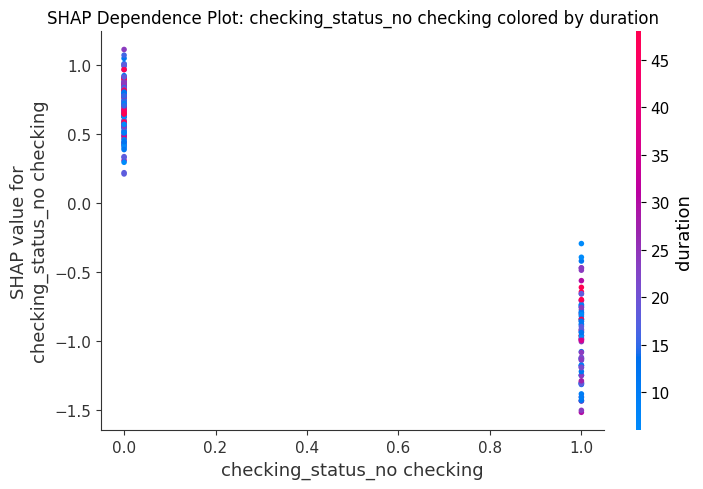

In [ ]:



print("--- 4. Complex Feature Interaction Analysis (Task 4) ---")


if len(top_10_features) >= 2:
    top_feature = top_10_features[0]
    second_feature = top_10_features[1]
else:

    top_feature = 'duration_in_month'
    second_feature = 'credit_amount'

print(f"Plotting {top_feature} vs. {second_feature} interaction: ")

plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feature,
                     shap_values_class1,
                     subset_X_test,
                     interaction_index=second_feature,
                     show=False)
plt.title(f"SHAP Dependence Plot: {top_feature} colored by {second_feature}")
plt.tight_layout()
plt.show()